In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize
import glob
import nltk
import re
import os
import sys
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [50]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ZBOOK\AppData\Roaming\nltk_data...


True

In [3]:
path = "datasets/"
filenames = glob.glob(path + "\*.xlsx")
print(f"File names {filenames}")

File names ['datasets\\conventional vs organic.xlsx', 'datasets\\organic agriculture.xlsx', 'datasets\\organic food.xlsx', 'datasets\\sustainable farming.xlsx']


In [4]:
outputxlsx = pd.DataFrame()

for file in filenames:
    df = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True, sort=False)
    outputxlsx = pd.concat([outputxlsx, df], )

print(outputxlsx)

     Unnamed: 0                                              topic content  \
0             0                                Buying organic food     NaN   
1             1  Harvesting your own food, 100% organic in a sp...     NaN   
2             2  TIL there is broad scientific consensus that f...     NaN   
3             3  Legal marijuana is the fastest-growing industr...     NaN   
4             4                         Store Cat Food vs Homemade     NaN   
..          ...                                                ...     ...   
224         224  || Awareness campaign for sustainable farming ...     NaN   
225         225  The Oscars Are Going (Mostly) Meatless This Ye...     NaN   
226         226  Local and sustainable and regeneratively-farme...     NaN   
227         227  Artificial Intelligence for Ethical and Sustai...     NaN   
228         228  My local Kroger finally carries cherry tomatoe...     NaN   

                         time            poster  \
0    2014-08

In [5]:
full_data = outputxlsx.drop(columns="Unnamed: 0")

In [6]:
content_data = full_data[["topic", "content", "time"]] \
    .dropna() \
    .reset_index() \
    .drop(columns="index") \
    .drop_duplicates()

content_data

,topic,content,time
0,I can't think of a single person I've ever gon...,Yet everyone in ethical veganism debates says ...,2021-11-24T14:33:48.594Z
1,CMV: All grocery stores should be forced by la...,"I know forced sounds extreme, but so is homele...",2021-12-14T00:55:11.463Z
2,Do you leave food out all the time or have sch...,I just leave food and water out for my cats so...,2023-05-29T19:59:23.578Z
3,"If you have food allergies, are there any that...",I was just talking about this and the question...,2019-06-22T06:04:32.466Z
4,AITA for refusing to pay for my boyfriend's fo...,I have an Instagram account dedicated to photo...,2023-05-23T15:36:55.919Z
...,...,...,...
258,Organic and Sustainable farming from Miditer,The journey from seed to table can be a long o...,2022-11-12T18:49:44.139Z
259,Any volunteering organisations specifically fo...,I was wondering if anyone knows of volunteerin...,2022-09-17T17:25:24.990Z
260,Personal Challenge: self-sustaining farm,Been playing my latest save for a while and th...,2022-06-27T18:06:43.328Z
261,Icelandic Greenhouse Experience: Unveiling the...,Step into the enchanting world of Icelandic gr...,2023-07-13T06:52:34.975Z


In [7]:
def percentage(val, total):
    return (val / total) * 100

In [8]:
positive = 0
negative = 0
neutral = 0
polarity =0

content_list = []
positive_list = []
negative_list = []
neutral_list = []

contents = content_data["content"]


for content in contents:
    #print(content)
    content_list.append(content)
    analysis = TextBlob(content)
    score = SentimentIntensityAnalyzer().polarity_scores(content)
    neg_score = score['neg']
    pos_score = score['pos']
    neu_score = score['neu']
    comp_score = score['compound']
    
    polarity += analysis.sentiment.polarity
    if neg_score > pos_score:
        negative_list.append(content)
        negative += 1
    elif neg_score < pos_score:
        positive_list.append(content)
        positive += 1
    elif neg_score == pos_score:
        neutral_list.append(content)
        neutral += 1
        
positive = percentage(positive, len(contents))
negative = percentage(negative, len(contents))
neutral = percentage(neutral, len(contents))
polarity = percentage(polarity, len(contents))

positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')



In [9]:
print(negative_list)
print(positive_list)
print(neutral_list)

print(positive)
print(negative)
print(neutral)
print(polarity)

["Yet everyone in ethical veganism debates says that's all they get. Curious🤔\nLike why do they just...lie about that lol. All the time.\nI know u eat Tyson chicken strips and Great Value ground beef. It's in the freezer rn. There's a McDonald's cup in ur room. I did the same thing...I don't expect people in their 20s making $9/hour to shop exclusively at Whole Foods, that's ridiculous. And the especially insane part is a lot of people who say that are like, my coworkers and family and former roommates....like I literally have seen the evidence that ur lying??? Or if it's someone on social media I can scroll through their profile for less than 5 minutes and see them talking about the new Burger King chicken sandwich or whatever.\nSure, they may be unaware that there's no ethical way to consume animal products so buying those doesn't actually make it okay. I totally get that. I was before too. But the fact is they do buy factory farmed products (either mostly or EXCLUSIVELY!) and are ly

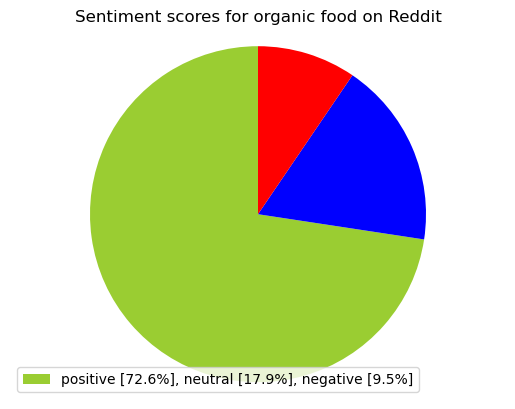

In [11]:
labels = [f'positive [{str(positive)}%], neutral [{str(neutral)}%], negative [{str(negative)}%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue', 'red']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.style.use("default")
plt.legend(labels)
plt.title("Sentiment scores for organic food on Reddit")
plt.axis('equal')
plt.show()